In [2]:
# import
import pandas as pd
import numpy as np
from shapely.wkt import loads
from haversine import haversine
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
from sklearn.neighbors import kneighbors_graph


In [ ]:
# load data
start = "../"
# start = "/mnt/c/Users/dalli/source/acme_senior/projectV3/"
nyc = pd.read_csv(start + 'data/nyc_map.csv')

weight_cols = ["the_geom", "STATUS", "BIKE_LANE", "ST_WIDTH", "TRAFDIR", "RW_TYPE", "SNOW_PRI", "PHYSICALID", "ST_LABEL", "BOROCODE"]

# drop columns not in weight_cols
nyc = nyc.drop([col for col in nyc.columns if col not in weight_cols], axis=1)

# get just the coordinates
node_locs = nyc["the_geom"]

In [5]:
# Extract coordinates from each row
coordinate_pairs = [a for row in node_locs for line in loads(row).geoms for a in list(line.coords)]

# Create a DataFrame from the extracted coordinates
coords = pd.DataFrame(coordinate_pairs, columns=['longitude', 'latitude'])

In [ ]:
train = pd.read_csv(start + 'data/train.csv')
min_lat = min(train["pickup_latitude"].min(), train['dropoff_latitude'].min())
min_long = min(train["pickup_longitude"].min(), train['dropoff_longitude'].min())
max_lat = max(train["pickup_latitude"].max(), train['dropoff_latitude'].max())
max_long = max(train["pickup_longitude"].max(), train['dropoff_longitude'].max())

In [8]:
# save the min and max lat and long for coords
min_lat = coords["latitude"].min()
max_lat = coords["latitude"].max()
min_long = coords["longitude"].min()
max_long = coords["longitude"].max()


(1458644, 11)
outside pickup latitude: (174, 11)
outside pickup longitude: (209, 11)
outside dropoff latitude: (677, 11)
outside dropoff longitude: (832, 11)
total: 1892


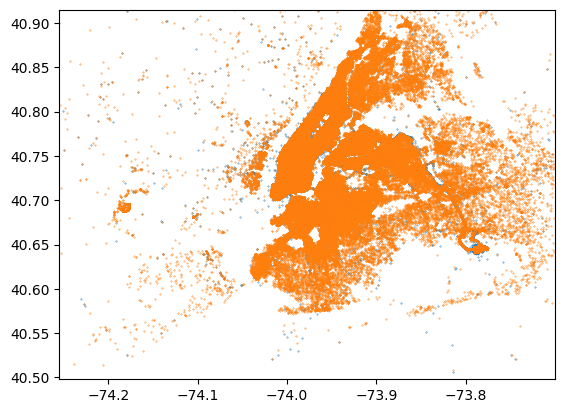

In [10]:
# make a scatter plot of coordinates in train
plt.scatter(train["pickup_longitude"], train["pickup_latitude"], s=0.1, alpha=0.1)
# plt.scatter(train["dropoff_longitude"], train["dropoff_latitude"], s=0.1)

# also plot the min and max coordinates from coords
plt.scatter(coords["longitude"].min(), coords["latitude"].min(), c="red")
plt.scatter(coords["longitude"].max(), coords["latitude"].max(), c="red")
plt.scatter(coords["longitude"].min(), coords["latitude"].max(), c="red")
plt.scatter(coords["longitude"].max(), coords["latitude"].min(), c="red")

# instead of plotting, set x and y limits to the min and max coordinates from coords
plt.xlim(coords["longitude"].min(), coords["longitude"].max())
plt.ylim(coords["latitude"].min(), coords["latitude"].max())
plt.show()

In [12]:
# write a function to find the closest point in coords to a given point
def closest_point(point, coords):

    # make a box with length 0.01 degrees around the point and filter coords
    topLeft = (point[0] - 0.01, point[1] + 0.01)
    bottomRight = (point[0] + 0.01, point[1] - 0.01)
    temp = coords[(coords['longitude'] > topLeft[0]) & (coords['longitude'] < bottomRight[0])]
    temp = temp[(temp['latitude'] < topLeft[1]) & (temp['latitude'] > bottomRight[1])]

    # Calculate Haversine distances for all remaining coordinates
    distances = np.array([haversine(point, (loc["longitude"], loc["latitude"])) for _, loc in temp.iterrows()])

    # Find the index of the minimum distance
    if len(distances) == 0:
        return None, None
    
    closest_index = np.argmin(distances)
    return distances[closest_index], temp.iloc[closest_index]

In [13]:
# test the function
point_test = (-73.935242, 40.730610)
res_dist, res_loc = closest_point(point_test, coords)

if res_dist == None:
    print("No points in range")
else:
    print("Distance:", res_dist)
    print(res_loc)


Distance: 0.014961526482056786
longitude   -73.935134
latitude     40.730318
Name: 330123, dtype: float64


longitude   -73.935134
latitude     40.730318
Name: 330123, dtype: float64

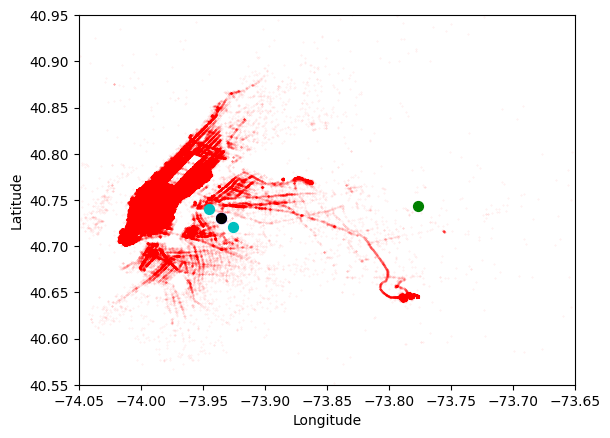

In [15]:
# make a scatter plot of coordinates in train
plt.scatter(train["pickup_longitude"], train["pickup_latitude"], s=0.1, alpha=0.1, c='r')
# plt.scatter(train["dropoff_longitude"], train["dropoff_latitude"], s=0.1, alpha=0.1, c='k')

# set x and y limits to the min and max coordinates from coords
plt.xlim(coords["longitude"].min(), coords["longitude"].max())
plt.ylim(coords["latitude"].min(), coords["latitude"].max())

# zoom in
plt.xlim(-74.05, -73.65)
plt.ylim(40.55, 40.95)

point_test = (-73.935242, 40.730610)
plt.scatter(point_test[0], point_test[1], c="b", s=50)
plt.scatter(-73.935134, 40.730318, c="k", s=50)
plt.scatter(-73.776036, 40.743794, c="g", s=50)

topLeft = (point_test[0] - 0.01, point_test[1] + 0.01)
bottomRight = (point_test[0] + 0.01, point_test[1] - 0.01)
plt.scatter(topLeft[0], topLeft[1], c="c", s=50)
plt.scatter(bottomRight[0], bottomRight[1], c="c", s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [16]:
# save the first pick up and drop off coordinates from train
pickup = (train["pickup_longitude"].iloc[0], train["pickup_latitude"].iloc[0])
dropoff = (train["dropoff_longitude"].iloc[0], train["dropoff_latitude"].iloc[0])
print("True pickup")
print(pickup)
print("True dropoff")
print(dropoff)

# find the closest point in coords to the pickup and dropoff
pickup_dist, pickup_loc = closest_point(pickup, coords)
dropoff_dist, dropoff_loc = closest_point(dropoff, coords)
print("\nApproximate pickup")
print(pickup_loc)
print("Error: " + str(pickup_dist))
print("Approximate dropoff")
print(dropoff_loc)
print("Error: " + str(dropoff_dist))

True pickup
(-73.98215484619139, 40.76793670654297)
True dropoff
(-73.96463012695312, 40.765602111816406)

Approximate pickup
longitude   -73.982166
latitude     40.767766
Name: 62410, dtype: float64
Error: 0.005376373430229066
Approximate dropoff
longitude   -73.964298
latitude     40.764682
Name: 8149, dtype: float64
Error: 0.046512803896980114


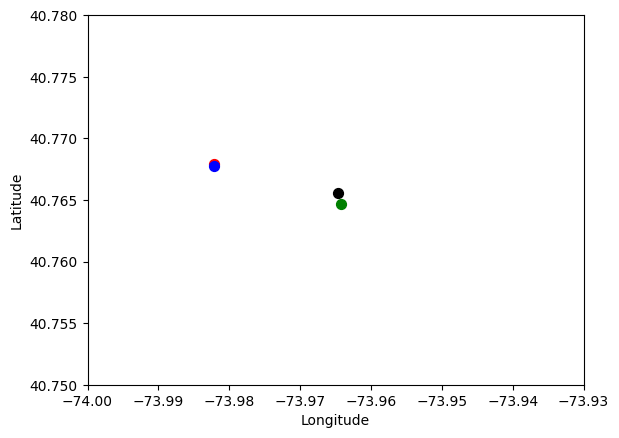

In [17]:
# plot the pickup and dropoff points, and their closest points in coords
plt.scatter(pickup[0], pickup[1], c="r", s=50)
plt.scatter(dropoff[0], dropoff[1], c="k", s=50)
plt.scatter(pickup_loc["longitude"], pickup_loc["latitude"], c="b", s=50)
plt.scatter(dropoff_loc["longitude"], dropoff_loc["latitude"], c="g", s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# zoom in
plt.xlim(-74.0, -73.93)
plt.ylim(40.75, 40.78)
plt.show()

In [50]:
# crop coords to a box around the pickup and dropoff approximations
topLeft = (min(pickup_loc["longitude"], dropoff_loc["longitude"]) - 0.001, 
           max(pickup_loc["latitude"], dropoff_loc["latitude"]) + 0.001)
bottomRight = (max(pickup_loc["longitude"], dropoff_loc["longitude"]) + 0.001, 
               min(pickup_loc["latitude"], dropoff_loc["latitude"]) - 0.001)
temp = coords[(coords['longitude'] > topLeft[0]) & (coords['longitude'] < bottomRight[0])]

# small_A = kneighbors_graph(temp, 4, mode='distance', metric='haversine', include_self=False)

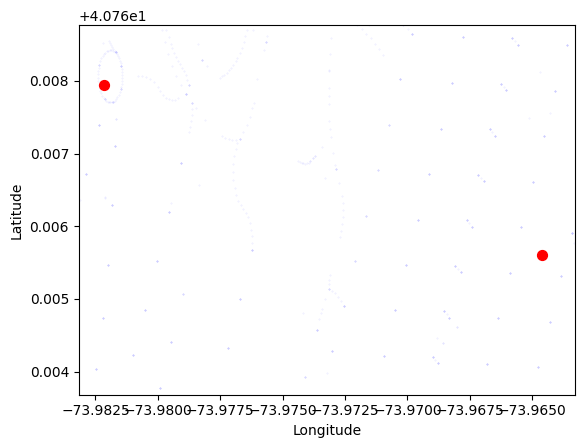

In [28]:
# show temp coord on top of al coords
plt.scatter(coords["longitude"], coords["latitude"], s=0.1, alpha=0.1, c='b')
plt.scatter(temp["longitude"], temp["latitude"], s=0.1, alpha=0.1, c='b')
plt.scatter(pickup[0], pickup[1], c="r", s=50)
plt.scatter(dropoff[0], dropoff[1], c="r", s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(topLeft[0], bottomRight[0])
plt.ylim(bottomRight[1], topLeft[1])
plt.show()

In [101]:
# crop coords to a box around the pickup and dropoff approximations
topLeft = (min(pickup_loc["longitude"], dropoff_loc["longitude"]) - 0.001, 
           max(pickup_loc["latitude"], dropoff_loc["latitude"]) + 0.001)
bottomRight = (max(pickup_loc["longitude"], dropoff_loc["longitude"]) + 0.001, 
               min(pickup_loc["latitude"], dropoff_loc["latitude"]) - 0.001)
temp = coords[(coords['longitude'] > topLeft[0]) & (coords['longitude'] < bottomRight[0])]
temp = temp[(temp['latitude'] < topLeft[1]) & (temp['latitude'] > bottomRight[1])]


# remove all points in temp that are closer than 0.001 to another point
print(temp.shape)
radius = 0.000003
# radius = 0.0002
temp = temp.drop_duplicates(subset=["longitude", "latitude"], keep="first")
loc_names = []
for _, loc in temp.iterrows():
    if len(temp[(temp['longitude'] > loc["longitude"] - radius) & (temp['longitude'] < loc["longitude"] + radius)]) > 1:
        loc_names.append(loc.name)
    elif len(temp[(temp['latitude'] > loc["latitude"] - radius) & (temp['latitude'] < loc["latitude"] + radius)]) > 1:
        loc_names.append(loc.name)
# save the ones that will be dropped to a new dataframe
dropped = temp.loc[loc_names]   
temp = temp.drop(loc_names)
print(temp.shape)

(509, 2)
(152, 2)


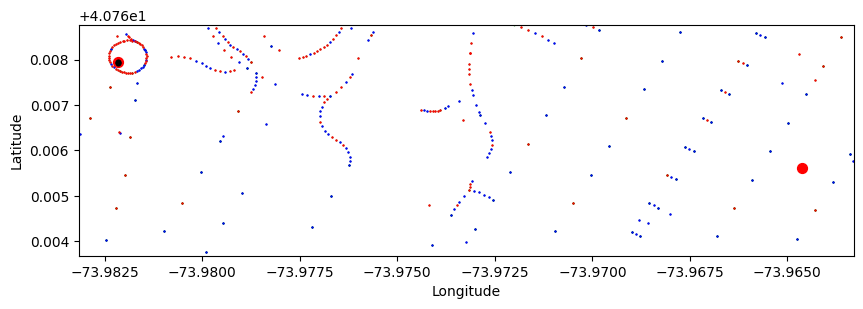

In [103]:
# show temp coord on top of al coords
plt.figure(figsize=(10,3))
plt.scatter(coords["longitude"], coords["latitude"], s=0.1, alpha=0.9, c='g')
plt.scatter(temp["longitude"], temp["latitude"], s=0.5, c='b')
plt.scatter(dropped["longitude"], dropped["latitude"], s=0.5, c='r')
plt.scatter(pickup[0], pickup[1], c="r", s=50)
plt.scatter(dropoff[0], dropoff[1], c="r", s=50)

plt.scatter(pickup[0]+radius, pickup[1]+radius, c="k", s=10)
plt.scatter(pickup[0]-radius, pickup[1]+radius, c="k", s=10)
plt.scatter(pickup[0]+radius, pickup[1]-radius, c="k", s=10)
plt.scatter(pickup[0]-radius, pickup[1]-radius, c="k", s=10)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(topLeft[0], bottomRight[0])
plt.ylim(bottomRight[1], topLeft[1])
plt.show()

In [112]:
print(temp.shape)
print(temp.index.values)

(152, 2)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151]


In [151]:
# find the shortest path between the pickup and dropoff approximations using temp
# make a sparse matrix from temp

temp.reset_index(drop=True, inplace=True)
temp_sparse = csr_matrix(kneighbors_graph(temp, 10, mode='distance', metric='haversine', include_self=False))

# find the shortest path
distances, predecessors = shortest_path(temp_sparse, directed=False, indices=temp.index.values, return_predecessors=True)

# calculate the length of the path
# length = path[pickup_index, dropoff_index]

# length = 0
# for i in range(len(path)-1):
#     length += haversine((temp.iloc[path[i]]["longitude"], temp.iloc[path[i]]["latitude"]), 
#                         (temp.iloc[path[i+1]]["longitude"], temp.iloc[path[i+1]]["latitude"]))
# print(length)

In [172]:
# print the ten nearest neighbors of index 100 using temp_sparce
n100 = temp_sparse[100].todense()
# get the indices of the ten nearest neighbors
n100_indices = np.argsort(n100)[0, :10]
print(n100_indices)
for n in n100_indices.tolist()[0]:
    print(n)

[[  0  96  97  98  99 100 102  95 103 106]]
0
96
97
98
99
100
102
95
103
106


In [165]:
# user predecessors to find the nodes between the shortest path from index 0 to 100
start_index = 0
end_index = 2

# Initialize the path list with the end index
path = [end_index]

# Trace back from the end node to the start node using predecessors
while path[-1] != start_index:
    prev_node = predecessors[start_index, path[-1]]
    path.append(prev_node)

# Reverse the list to obtain the correct order of nodes
path = path[::-1]

print(path)


[0, 1, 2]


In [150]:
start_index = 0
end_index = 100

# Trace the path using the 'indices' matrix to reconstruct the shortest path
trace = [start_index]
current_index = start_index
indices = path

In [ ]:
# Extract the coordinates of the nodes forming the reconstructed path
path_coords = temp[['latitude', 'longitude']].iloc[trace]
path_coords.head()

longitude   -73.977197
latitude     40.764324
Name: 0, dtype: float64
longitude   -73.982166
latitude     40.767766
Name: 62410, dtype: float64
0.14136605395558904


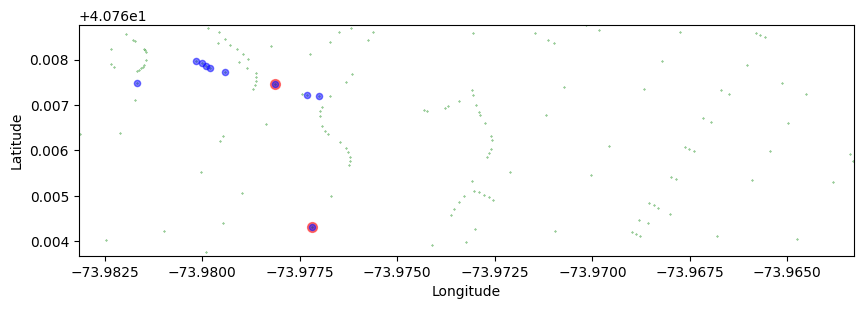

In [174]:
# show the first element of temp
print(temp.iloc[0])
print(pickup_loc)

# find the path from the first element of temp to the 100th
# print(path[0][100])

# print the haversine distance between these elements
print(haversine((temp.iloc[0]["longitude"], temp.iloc[0]["latitude"]), 
                (temp.iloc[100]["longitude"], temp.iloc[100]["latitude"])))

# print(path[0][1] + path[1][2])

# plot the path
plt.figure(figsize=(10,3))
plt.scatter(temp["longitude"].iloc[0], temp["latitude"].iloc[0], s=50, c='r', alpha=0.5)
plt.scatter(temp["longitude"].iloc[100], temp["latitude"].iloc[100], s=50, c='r', alpha=0.5)
plt.scatter(temp["longitude"], temp["latitude"], s=0.1, alpha=0.9, c='g')

# plot the locations determined by n100_indices
for i in n100_indices.tolist()[0]:
    plt.scatter(temp["longitude"].iloc[i], temp["latitude"].iloc[i], s=20, c='b', alpha=0.5)




plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(topLeft[0], bottomRight[0])
plt.ylim(bottomRight[1], topLeft[1])
plt.show()


In [129]:
# print the non inf values in path[0] along with the indices
for i in range(len(path[0])):
    if path[0][i] != np.inf:
        print(i, path[0][i])

0 0.0
1 0.000503691524844604
2 0.0009837523977518658
4 0.0031790119356702494
5 0.002676827884120533
12 0.001003140782468102
13 0.00100125551739427
14 0.0009762935373080048
15 0.0009294091608526184
16 0.0007932780903324968
17 0.0005195092184351614
18 0.0004609120603323253
19 0.0004249016445797651
20 0.0004164879855698132
21 0.000436022355851305
22 0.00046826068854366557
23 0.0006362999997570381
38 0.0019192604629842862
39 0.0021246107399547818
40 0.002658126336618565
41 0.002919801049827536
42 0.0016946612416611122
90 0.0017547123413263594
91 0.0017121127205012815
92 0.0016874635680188444
93 0.0016818246480266989
95 0.0032140721654706525
96 0.0030744929733498893
97 0.0029776371897946136
98 0.002867148327596418
99 0.0024876818938308395
100 0.0011843331750578628
101 0.0004997254310665206
102 0.0004439203341950694
103 0.00046425625388996533
104 0.0014551644358195555
105 0.0025869764309070166
110 0.0031469417428616523
111 0.0026865560959610005
112 0.0021983731838216003
119 0.001044338803379

In [ ]:
# load data
start = "../"
# start = "/mnt/c/Users/dalli/source/acme_senior/projectV3/"
train = pd.read_csv(start + 'data/train.csv')
test = pd.read_csv(start + 'data/test.csv')

# show the first and last times in the test set pickup_datetime
# concert the pickup_datetime column to a datetime object
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train["dropoff_datetime"] = pd.to_datetime(train["dropoff_datetime"])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

print("Date Range:")
print(train['pickup_datetime'].min())
print(train['pickup_datetime'].max())

print("\nGrid Range:")
min_lat = min(train["pickup_latitude"].min(), train['dropoff_latitude'].min())
min_long = min(train["pickup_longitude"].min(), train['dropoff_longitude'].min())
max_lat = max(train["pickup_latitude"].max(), train['dropoff_latitude'].max())
max_long = max(train["pickup_longitude"].max(), train['dropoff_longitude'].max())
print(min_lat, min_long)
print(max_lat, max_long)

# drop extra columns
train = train.drop(['id', 'vendor_id', "store_and_fwd_flag", 'dropoff_datetime'], axis=1)
test = test.drop(['id', 'vendor_id', "store_and_fwd_flag"], axis=1)

# apply the floor("H") operation to every row in test["hour"]
# train['hour'] = train['pickup_datetime'].apply(lambda date: date.floor('H'))
train['hour'] = train['pickup_datetime'].dt.floor('H')
test['hour'] = test['pickup_datetime'].dt.floor('H')

Date Range:
2016-01-01 00:00:17
2016-06-30 23:59:39

Grid Range:
32.1811408996582 -121.93334197998048
51.88108444213867 -61.33552932739258


In [ ]:
# print the average the the quartiles of the latitude and longitude
print("Latitude:")
print("Mean:", (np.mean(train["pickup_latitude"]) + np.mean(train["dropoff_latitude"]))/2)
print("25th:", np.percentile(train["pickup_latitude"], 25))
print("50th:", np.percentile(train["pickup_latitude"], 50))
print("75th:", np.percentile(train["pickup_latitude"], 75))

print("\nLongitude:")
print("Mean:", np.mean(train["pickup_longitude"]))
print("25th:", np.percentile(train["pickup_longitude"], 25))
print("50th:", np.percentile(train["pickup_longitude"], 50))
print("75th:", np.percentile(train["pickup_longitude"], 75))

Latitude:
Mean: 40.75136021164597
25th: 40.73734664916992
50th: 40.754100799560554
75th: 40.768360137939446

Longitude:
Mean: -73.97348630489282
25th: -73.9918670654297
50th: -73.98174285888672
75th: -73.96733093261719


In [ ]:
# load weather data
# https://www.kaggle.com/datasets/aadimator/nyc-weather-2016-to-2022
weather = pd.read_csv(start + 'data/weather.csv')
weather = weather.dropna()

# drop all rows where the time is after 2016-07-01
weather['time'] = pd.to_datetime(weather['time'])
weather = weather[weather['time'] <= '2016-07-01']

# drop extraneous columns and show
weather = weather.drop(columns=['rain (mm)', 'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)'])
print(weather['time'].min())
print(weather['time'].max())

2016-01-01 00:00:00
2016-07-01 00:00:00


In [ ]:
# left join test and weather on hour == time
taxis = train.merge(weather, left_on='hour', right_on='time', how='left')
taxis = taxis.drop(columns=['time', 'hour'])
validation = test.merge(weather, left_on='hour', right_on='time', how='left')
validation = validation.drop(columns=['time', 'hour'])